# Estimating completion date using burndown chart

One of the techniques in Agile planning is burndown chart. According to [Wikipedia](https://en.wikipedia.org/wiki/Burn_down_chart), it is  a graphical representation of work left to do versus time. It is extremely simple chart, but also extremely important, because it allows to answer a very important question: when are we going to be done. Indeed, when the line crosses the x-axis, this is the date we are done. 

The problem is, as we showed in the previous examples, this approach does not take into account uncertainty. The project velocity varies over time, and we can predict the time we are going to be done only with a certain degree of probability. Here I will be using ARIMA to model the time series data and do forecasting.

## Book progress
When I learned the burndown chart tecnique, I started using it for everything that requires tracking of progress, including books. I like to set goals for myself as to when I have to finish the book. Otherwise I'll never get done with the book. The natural method of tracking book progress is a burndown chart, so I tend to use it for all the technical books I read. 

In this example I share the data for one of the very important book on machine learning, that I read back in 2018. Every week I udpate the number of pages read, and Excel calculates for me the number of remaining pages. 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA

In [2]:
book_raw_data = pd.read_csv('book.csv')
book_raw_data.Date = pd.to_datetime(book_raw_data.Date)
book_raw_data

,Date,Page,Remaining
0,2017-12-25,0,441
1,2018-01-01,38,403
2,2018-01-08,100,341
3,2018-01-15,122,319
4,2018-01-22,167,274
5,2018-01-29,250,191
6,2018-02-05,295,146
7,2018-02-12,352,89
8,2018-02-19,388,53
9,2018-02-26,416,25


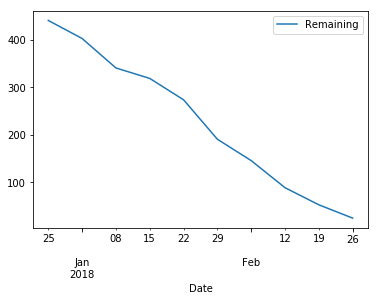

In [3]:
book_raw_data.plot(x='Date', y='Remaining');

I was trying to read 50 pages per week, and if I was under my goal one week, I would try to complensate in the next week by dedicating more times to the book. I was tracking data in Excel document, and was using a very simple chart with a linear trendline:
<img src='burndown_excel.png'>
Linear trendline works... sort of. It does not reflect the reality as soon as my variation increases. Shouldn't I use machine learning methods instead? 

## ARIMA model
ARIMA, according to (Wikipedia)[https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average], stands for autoregressive integrated moving average. It has three important parameters: p, d and q. p is responsible for the degree of autoregression, i.e. how the previous results influence the current result. q represents the degree of moving average, i.e. how previous noise influences the current result. If we assume that the current result is influences only by the current noise, then we can set q to zero. Finally, d represents the degree of differencing. This means, that rather than fitting the actual result, we are fitting the difference between the current and the previous result. It is also equivalent to the time derivative. When d = 1 we fit the first derivative, when d = 2 - the second, etc. 

In our example we see that we can model the data as a straight line with a negative slope, so we can set d to 1. We also assume, that the reasons for variance in the previous week has no effect on the current week, so we set q to zero. Finally, in our simplistic model we assume that the current week directly depends only on the result of the previous week, and not on the data for the preceding weeks. Hence we will fit the model (1,1,0).


In [4]:
model = ARIMA(book_raw_data.Remaining.iloc[:5], order=(1,1,0)) #I tried (1,1,1) and (1,1,0), but got higher AIC and worse coefficient
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Remaining   No. Observations:                    4
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -15.400
Method:                       css-mle   S.D. of innovations             10.857
Date:                Fri, 01 Mar 2019   AIC                             36.800
Time:                        15:01:36   BIC                             34.959
Sample:                             1   HQIC                            32.760
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -41.8044      3.849    -10.862      0.008     -49.348     -34.261
ar.L1.D.Remaining    -0.5563      0.330     -1.688      0.233      -1.202       0.090
                        

According to this summary the model does not fit very well, but we should not forget, that our time series is very short. In fact, this is very typical of time series to contain relatively few data, so if we apply more complex models, we either get a warning from `ARIMA.fit()` method, or the model will overfit. 

Below we simulated the case when we forecast the end date of the book starting week 4.

In [43]:
def forecast(weeks, week_range=15):
    '''Print forecast 
    param weeks:      The number of weeks we use for model training
    param week_range: The total range of weeks we use for both data and forecast

    '''
    model = ARIMA(book_raw_data.Remaining.iloc[:weeks], order=(1,1,0))
    model_fit = model.fit(disp=0)
    ax = plt.subplot(111)
    book_raw_data.iloc[:weeks].reset_index().plot(x='index', y='Remaining', ax=ax, color='k');
    plt.xlim(0, week_range)
    plt.ylim(0, book_raw_data.Remaining.max() + 20)
    model_fit.plot_predict(start=weeks-1, end=week_range, ax=ax);

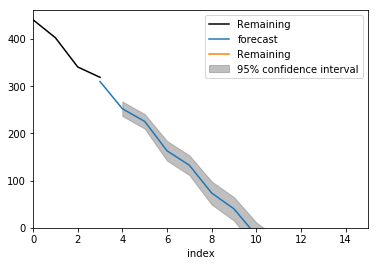

In [44]:
forecast(4)


We see that after only 4 weeks of data the model seems to be overfitting, because the forecast follows the squiggly pattern we had during the first 4 weeks of this book. The forecast comes just below 10 weeks with 95% cofidence interval between 9 and 11 weeks.

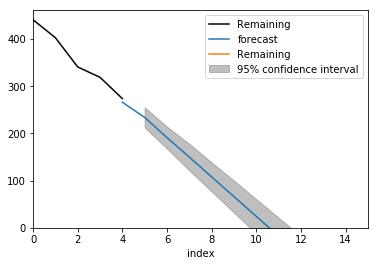

In [45]:
forecast(5)

After the week 5 the model no longer overfits. Now the width of the 95% confidence interval is almost 2 weeks!

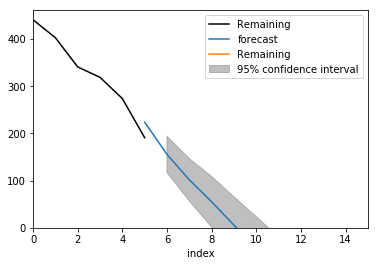

In [46]:
forecast(6)

I think I had way too much time in week 6, so I managed to catch up in my reading. Now forecast is around 9 weeks, but look at the confidence interval: it is almost 3 weeks! This means that I could finish the book anytime between 8 to 11 weeks.

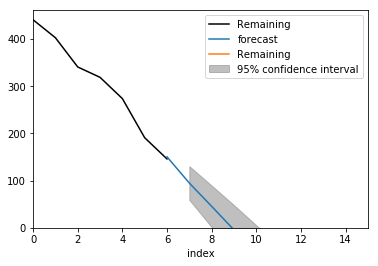

In [47]:
forecast(7)

After week 7 the confidence interval started to go down. The forecast is now around 9 weeks.

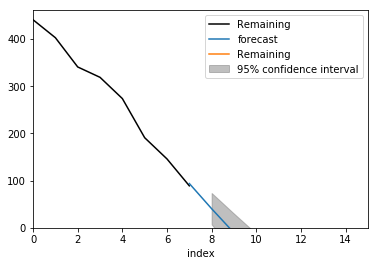

In [48]:
forecast(8)

Not much change in the forecast, however the confidence interval decreased further

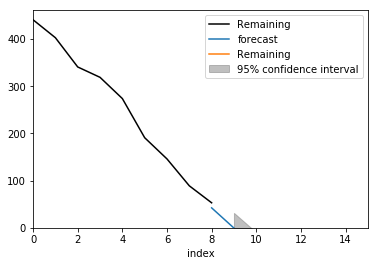

In [49]:
forecast(9)

Here is where the model seems to break down. The forecast is around 9, and the confidence interval is between 9 and 10. The reason is that the `ARIMA.plot_predict()` function estimates the uncertainty of the result, not the point the curve hits the x axis. To do the latter correctly, we will have to update the statistical modelwe use in estimating the confidence intervals.

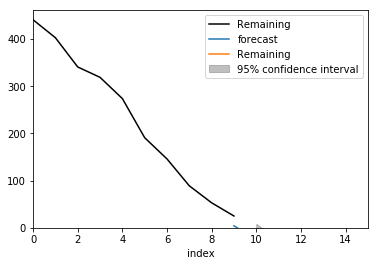

In [50]:
forecast(10)

Our week 10 forecast does not make much sense. Obviously we need one more week, but the forecast shows zero right now. Perhaps a more complex model can address the issue, now that we have more data to make sure the model won't overfit.

## Conclusion and Next Steps

We have shown, that instead of a trend line in Excel, we can use ARIMA model to forecast the progress of the project, estimate at every stage of the process when we will be done, and have the model give us confidence intervals to build in uncertainty in the estimation. It should not be too difficult to build this model into popular Agile development tools. I will also start using this tool for tracking progress of the books I am currently reading